# Tabular Variational Autoencoder
This simple tutorial shows how to train a Variational Autoencoder (VAE) on a small table and generate synthetic rows. It's designed for a non-technical audience, so follow along step by step.

## 1. Setup
Run the cell below to install the required libraries. If you're running in an environment that already has them, this step will finish quickly.

In [2]:
!pip install torch pandas scikit-learn --quiet

## 2. Load a sample dataset
We'll use the classic Iris flower dataset that comes with scikit-learn.


What is the Iris Dataset:

- Collected by Edgar Anderson; made famous by Ronald Fisher in 1936.
- It contains 150 samples (rows) of iris flowers
- There are 3 species of iris in the dataset:
   1. Iris setosa (50 Samples)
   2. Iris versicolor (50 Samples)
   3. Iris virginica (50 Samples)
- Each sample has 4 features (numeric measurements):
  1. Sepal length (cm)
  2. Sepal width (cm)
  3. Petal length (cm)
  4. Petal width (cm)


# Step 1: Loading the Iris data set in Python in dataframe format

In [1]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()





,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.1,2.8,4.7,1.2
1,5.7,3.8,1.7,0.3
2,7.7,2.6,6.9,2.3
3,6.0,2.9,4.5,1.5
4,6.8,2.8,4.8,1.4


## 2D Visalization

Create 2D scatter plot of the features.  
- we visualize, sepal length amd petal width. 
- as next step try with various feature combination
- can you draw any conclousion from the observation?



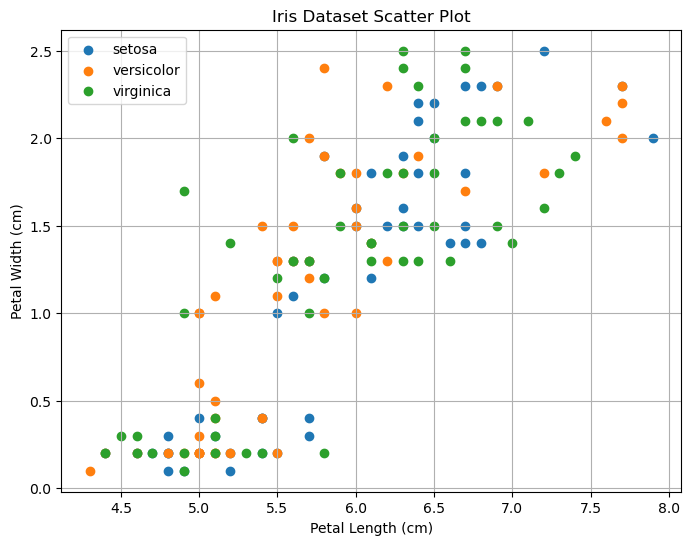

In [2]:
import matplotlib.pyplot as plt

# Add target to your DataFrame
data['target'] = iris.target
data['target_name'] = data['target'].map({i: name for i, name in enumerate(iris.target_names)})

# Scatter plot
plt.figure(figsize=(8,6))
for species in data['target_name'].unique():
    subset = data[data['target_name'] == species]
    plt.scatter(subset['sepal length (cm)'],
                subset['petal width (cm)'],
                label=species)

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Iris Dataset Scatter Plot')
plt.grid(True)
plt.legend()
plt.show()


## 3D Visalization

Create 3D scatter plot of the features.  
- we visualize, sepal length amd petal width. 
- as next step try with various feature combination
- can you draw any conclousion from the observation?

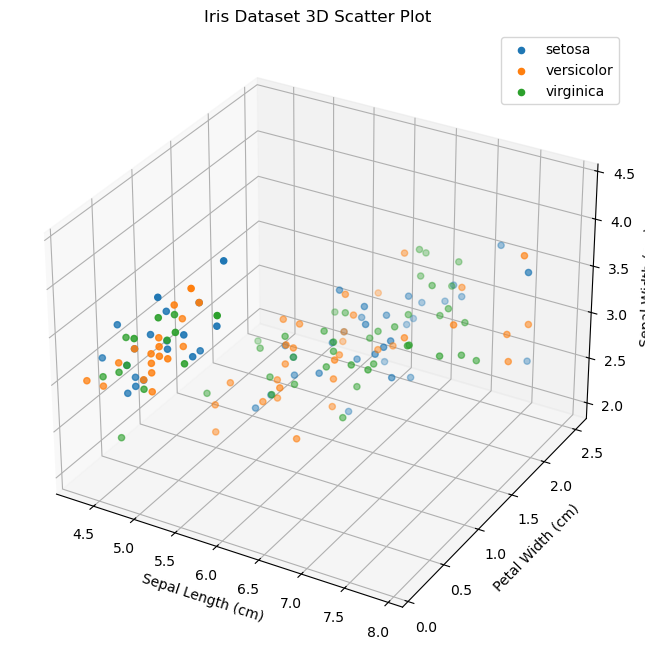

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each species
for species in data['target_name'].unique():
    subset = data[data['target_name'] == species]
    ax.scatter(subset['sepal length (cm)'],
               subset['petal width (cm)'],
               subset['sepal width (cm)'],
               label=species)

# Labels and title
ax.set_xlabel('Sepal Length (cm)')
ax.set_ylabel('Petal Width (cm)')
ax.set_zlabel('Sepal Width (cm)')
ax.set_title('Iris Dataset 3D Scatter Plot')
ax.legend()

plt.show()

# Principal Component Analysis (PCA) Visualization

- Plotting multi dimensional data is limited to 3D therefore it is hard to interprete or impossible to interpret multi-dimensional data and drive insight from. 
- We can use dimensionality reduction techniques such as PCA with compacted important information

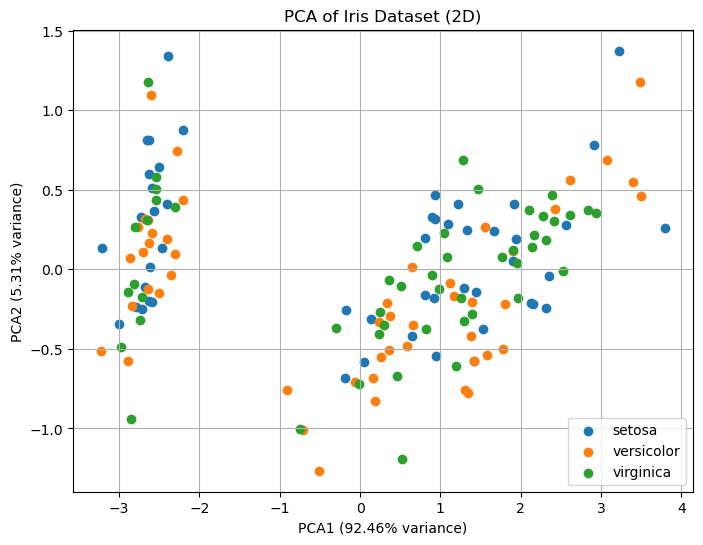

In [12]:
from sklearn.decomposition import PCA
# Apply PCA: reduce 4D → 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data[iris.feature_names])

# Add PCA results to DataFrame
data['PCA1'] = principal_components[:, 0]
data['PCA2'] = principal_components[:, 1]

# Plot
plt.figure(figsize=(8,6))
for species in data['target_name'].unique():
    subset = data[data['target_name'] == species]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=species)

plt.xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('PCA of Iris Dataset (2D)')
plt.legend()
plt.grid(True)
plt.show()

iris.target

## 3. Build a simple VAE
This VAE has two main parts: an encoder that compresses the data and a decoder that rebuilds it.

In [4]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [8]:
VAE

__main__.VAE

## 4. Train the model
We'll train for just a few epochs because the dataset is small.

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(data.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = VAE(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    for batch in loader:
        batch = batch[0]
        recon, mu, logvar = model(batch)
        recon_loss = nn.functional.mse_loss(recon, batch)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: loss={loss.item():.4f}')


Epoch 0: loss=11.1449
Epoch 10: loss=2.1935
Epoch 20: loss=1.0104
Epoch 30: loss=1.3340
Epoch 40: loss=0.8736


In [9]:
X = torch.tensor(data.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

## 5. Generate new synthetic rows
After training, we can sample new rows from the model.

In [13]:
for batch in loader:
    batch = batch[0]
    recon, mu, logvar = model(batch)
    break

Matplotlib is building the font cache; this may take a moment.


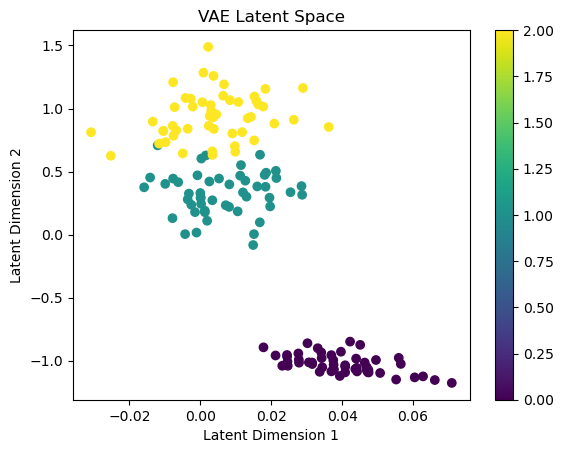

In [18]:
embed = model.encode(X)[0].detach().numpy()
import matplotlib.pyplot as plt
plt.scatter(embed[:, 0], embed[:, 1], c=iris.target)
plt.colorbar()
plt.title('VAE Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [21]:
embeddings = embed
embeddings.shape

(150, 2)

In [16]:
recon.shape, mu.shape, logvar.shape


(torch.Size([16, 4]), torch.Size([16, 2]), torch.Size([16, 2]))

In [6]:
with torch.no_grad():
    z = torch.randn(5, 2)
    synthetic = model.decode(z).numpy()
synthetic_df = pd.DataFrame(synthetic, columns=iris.feature_names)
synthetic_df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,4.973775,3.257425,1.819428,0.373154
1,7.985311,2.981492,7.748984,2.846972
2,6.866119,2.770091,6.220477,2.242729
3,5.554384,3.120963,3.140249,0.933532
4,6.048673,2.952152,4.390770,1.460567


You're now ready to adapt this notebook to your own tables. Replace the dataset loading step with your data and retrain the model.